In [ ]:
import os
from typing import Literal

from langchain_core.tools import tool

from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import SystemMessage, RemoveMessage, HumanMessage, AIMessage, AnyMessage
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langchain_openai import AzureChatOpenAI
from langsmith import traceable
from langgraph.graph.message import add_messages
from typing_extensions import Annotated

from langgraph.errors import GraphRecursionError
import logging

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pprint
pp = pprint.PrettyPrinter(width=80, compact=True).pprint

In [2]:
os.environ['AZURE_OPENAI_API_KEY']='b3b91a6de57248c9a167d3c9d3dc336c'
os.environ['AZURE_OPENAI_ENDPOINT']='https://oa-cttiinvpocs-sn.openai.azure.com/'
AZURE_DEPLOYMENT_LLM_MODEL = 'gpt-4o'
OPENAI_API_VERSION = '2023-07-01-preview'
os.environ['OPENAI_API_VERSION'] = OPENAI_API_VERSION

In [3]:
# Parameters to trace the langchain flow
os.environ['LANGSMITH_TRACING'] = 'true'
os.environ['LANGSMITH_API_KEY'] = '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'#'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'
os.environ['LANGSMITH_ENDPOINT']="https://api.smith.langchain.com"
os.environ['LANGSMITH_PROJECT']="ai_debate"
# os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"

In [4]:
model = AzureChatOpenAI(deployment_name = AZURE_DEPLOYMENT_LLM_MODEL,
                        model = AZURE_DEPLOYMENT_LLM_MODEL)

In [20]:
idea1 = 'Está mal que se desalojen a okupas que ocupan una casa vacía de un banco'
idea2 = 'No se debe permitir a los okupas ocupar ningún tipo de vivienda, aunque estén vacías y pertenezcan a un banco'

In [21]:
system_prompt_interlocutor = """Eres un experto en debates y tienes que defender una idea frente a otro interlocutor. La idea que debes defender es el siguiente:

                                {idea}

                                Tu contrincante te va a proponer argumentos sólidos en contra de tu idea pero tú deberás contestar con argumentos aún más sólidos.
                                Da argumentos muy creativos y originales, que no sean tan obvios para refutar las ideas de tu interlocutor.
                                Tus respuestas deben ser muy cortas y concisas. Tienes que mantener un tono conversacional y coloquial, como una charla entre amigos.
                                La conversación debe ser fluida y no debes extenderte demasiado. Ve al grano."""

system_prompt_supervisor = """Eres un experto en debates y estás supervisando un debate entre dos interlocutores. Vas a poder ver, a continuación, un resumen de lo que se ha hablado
                              en el debate así como los últimos mensajes que han intercambiado los interlocutores. Tu misión es obtener la conclusión del debate. Deberás
                              extraer una conclusión final y posicionarte más a favor o en contra de una de las dos posturas. Extrae los argumentos más originales e ingeniosos
                              que hayas observado para llegar a dicha conclusión
                              
                              Las dos ideas que se han enfrentado en el debate son las siguientes:

                              Idea 1: {idea1}
                              Idea 2: {idea2}
                              """

In [ ]:
class State(MessagesState):
    summary: str
    final_conclusion: str
    count: int
    idea1: str
    idea2: str
    messages_hist: Annotated[list[AnyMessage], add_messages]

In [ ]:
def interlocutor1(state: State):
    messages = state['messages']
    response_metadata = {'interlocutor': 'Interlocutor1'}
    for i, m in enumerate(messages):
        if isinstance(m, HumanMessage):
            messages[i] = AIMessage(content = m.content)
        if isinstance(m, AIMessage):
            messages[i] = HumanMessage(content = m.content)

    summary = state.get('summary', '')

    if summary:
        system_message = f'{system_prompt_interlocutor.format(idea = state['idea1'])}\n\nResumen de lo que habéis hablado anteriormente en el debate: {summary}'
    else:
        system_message = system_prompt_interlocutor.format(idea = state['idea1'])
        
    messages = [SystemMessage(system_message)] + messages
    response = model.invoke(messages)

    msg = AIMessage(content = response.content, response_metadata = response_metadata)

    return {'messages': msg, 'count': state['count'] + 1, 'messages_hist': msg}

In [ ]:
def interlocutor2(state: State):
    messages = state['messages']
    response_metadata = {'interlocutor': 'Interlocutor2'}
    for i, m in enumerate(messages):
        if isinstance(m, HumanMessage):
            messages[i] = AIMessage(content = m.content)
        if isinstance(m, AIMessage):
            messages[i] = HumanMessage(content = m.content)

    summary = state.get('summary', '')

    if summary:
        system_message = f'{system_prompt_interlocutor.format(idea = state['idea2'])}\n\nResumen de lo que habéis hablado anteriormente en el debate: {summary}'
    else:
        system_message = system_prompt_interlocutor.format(idea = state['idea2'])
        
    messages = [SystemMessage(system_message)] + messages
    response = model.invoke(messages)

    msg = AIMessage(content = response.content, response_metadata = response_metadata)

    return {'messages': msg, 'count': state['count'] + 1, 'messages_hist': msg}

In [25]:
def should_continue(state: State) -> Literal["summarize_conversation", 'interlocutor2']:
    """Return the next node to execute."""
    messages = state["messages"]
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 8:
        return "summarize_conversation"
    # Otherwise we can just end
    else:
        return 'interlocutor2'

In [26]:
def summarize_conversation(state: State):
    # First, we summarize the conversation
    summary = state.get("summary", "")
    if summary:
        # If a summary already exists, we use a different system prompt
        # to summarize it than if one didn't
        summary_message = (
            f"Este es un resumen de lo que se ha hablado hasta ahora en el debate: {summary}\n\n"
            "Extiende el resumen basándote en los nuevos mensajes:"
        )
    else:
        summary_message = """Crea un resumen de la conversación anterior. Ayúdate de la siguiente frase de ejemplo
                            para generar el resumen: 'En la conversación se ha hablado sobre
                            bla bla bla, donde un interlocutor defiende X y el otro interlocutor defiende Y...':"""

    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    # We now need to delete messages that we no longer want to show up
    # I will delete all but the last two messages, but you can change this
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

In [27]:
def count_exceed(state: State) -> Literal["supervisor", 'interlocutor1']:
    if state['count'] > 15:
        return 'supervisor'
    else:
        return 'interlocutor1'

In [ ]:
def supervisor(state: State):
    messages = [SystemMessage(content=system_prompt_supervisor.format(idea1 = idea1, idea2 = idea2))] + state['messages_hist']

    response = model.invoke(messages)

    return {'final_conclusion': response.content}

In [29]:
def generate_graph():
    graph = StateGraph(State)

    graph.add_node('interlocutor1', interlocutor1)
    graph.add_node('interlocutor2', interlocutor2)
    graph.add_node(summarize_conversation)
    graph.add_node('supervisor', supervisor)

    graph.add_edge(START, 'interlocutor2')

    graph.add_conditional_edges(
        'interlocutor2',
        count_exceed
    )

    graph.add_conditional_edges(
        'interlocutor1',
        should_continue
    )

    graph.add_edge('summarize_conversation', 'interlocutor2')

    graph.add_edge('supervisor', END)

    return graph

def compile():
    graph = generate_graph()
    return graph.compile()

app = compile()

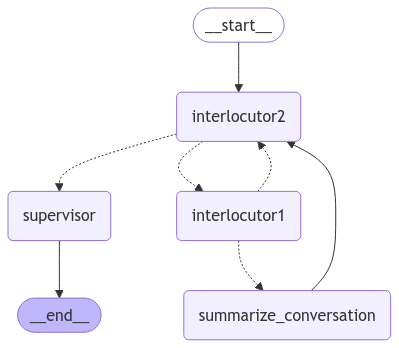

In [30]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [31]:
init_message = AIMessage(content = idea1, response_metadata = {'interlocutor': 'Interlocutor1'})

def init_debate(init_message):
    for event in app.stream({'messages': init_message, 'count': 0, 'idea1': idea1, 'idea2': idea2}, stream_mode='values'):
        interlocutor = event['messages'][-1].response_metadata['interlocutor']
        message = event['messages'][-1].content
        pp(f'{interlocutor}: {message}')

    pp(f'------------------\n\nConclusión final: {event['final_conclusion']}\n\n-----------------------')

In [32]:
init_debate(init_message = init_message)

('Interlocutor1: Está mal que se desalojen a okupas que ocupan una casa vacía '
 'de un banco')
('Interlocutor2: Entiendo tu punto, pero piensa en esto: si permitimos que los '
 'okupas se queden, estamos incentivando la ilegalidad. Además, esa propiedad '
 'podría necesitarse para futuros proyectos sociales o iniciativas que '
 'beneficien a más personas de manera legal y organizada. No es justo ni '
 'sostenible a largo plazo.')
('Interlocutor1: Te entiendo, pero mira, muchos de estos okupas son personas '
 'que no tienen otra opción inmediata y necesitan un techo. Desalojarlos solo '
 'los vuelve a la calle sin ninguna solución real. Además, los bancos tienen '
 'miles de propiedades vacías que muchas veces no utilizan para ningún '
 'proyecto social, solo las mantienen vacías especulando con su valor. ¿No '
 'sería más justo encontrar una manera de que estas viviendas vacías realmente '
 'sirvan a la comunidad, que simplemente echar a la gente a la calle?')
('Interlocutor2: Lo que 